## Password_Strength_Classifier


### import package

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import random,string
import matplotlib.pyplot as plt
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import balanced_accuracy_score, roc_auc_score, accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn import linear_model

from sklearn import model_selection
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF

### Exploratory Analysis & Preprocessing

b'Skipping line 41864: expected 2 fields, saw 5\nSkipping line 46861: expected 2 fields, saw 5\nSkipping line 58782: expected 2 fields, saw 5\nSkipping line 94776: expected 2 fields, saw 5\nSkipping line 106872: expected 2 fields, saw 5\nSkipping line 190264: expected 2 fields, saw 5\nSkipping line 226293: expected 2 fields, saw 5\nSkipping line 239626: expected 2 fields, saw 5\nSkipping line 296643: expected 2 fields, saw 5\nSkipping line 366534: expected 2 fields, saw 5\nSkipping line 377759: expected 2 fields, saw 5\nSkipping line 392604: expected 2 fields, saw 5\nSkipping line 396939: expected 2 fields, saw 5\nSkipping line 439776: expected 2 fields, saw 5\nSkipping line 476281: expected 2 fields, saw 5\nSkipping line 478322: expected 2 fields, saw 5\nSkipping line 489063: expected 2 fields, saw 5\nSkipping line 526251: expected 2 fields, saw 5\nSkipping line 534146: expected 2 fields, saw 5\nSkipping line 553002: expected 2 fields, saw 5\nSkipping line 553883: expected 2 fields, s

Sample data size:(49973, 2)
      password  strength
0    visi7k1yr         1
1     asv5o9yu         1
2  0169395484a         1
3       d04m11         0
4   hodygid757         1


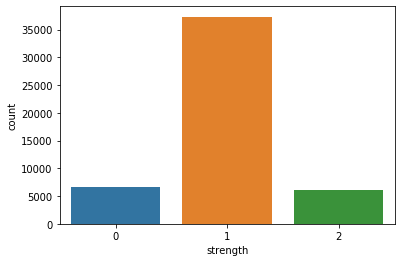

In [4]:
filename = './data_kaggle.csv'
# Count the lines
num_lines = sum(1 for l in open(filename))
# Sample size - in this case ~10%
size = 50000 #int(num_lines / 10)
# The row indices to skip - make sure 0 is not included to keep the header!
random.seed(33)
skip_idx = random.sample(range(1, num_lines), num_lines - size)
data = pd.read_csv(filename,skiprows=skip_idx, error_bad_lines = False)
data.dropna(inplace=True) # drop NaN row
print(f"Sample data size:{data.shape}\n{data.head()}")
sns.countplot(data['strength']) # Distribution graphs
plt.show()

### Using zxcvbn to analyse data

Sample data:(7993, 3)
           password  strength  newLabel
0       0169395484a         1         4
1            d04m11         0         1
2        hodygid757         1         3
3          abizar08         1         2
4  jEzZXUTE3MgJ4fVk         2         4
value distribution: 3    2605
2    2278
4    1626
1    1479
0       5
Name: newLabel, dtype: int64


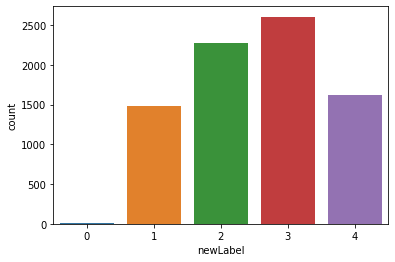

In [193]:
from zxcvbn import zxcvbn
data['newLabel'] = data['password'].apply(lambda x: zxcvbn(x)['score'])
print(f"Sample data:{data.shape}\n{data.head()}")
print("value distribution:",data['newLabel'].value_counts())
sns.countplot(data['newLabel']) # Distribution graphs

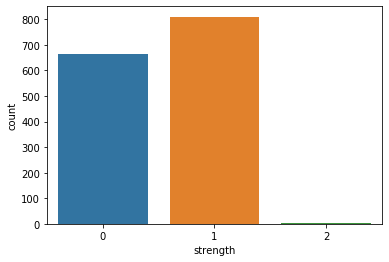

In [219]:
# sns.countplot(data[data.strength==1]['newLabel'])
sns.countplot(data[data.newLabel==1]['strength'])
# data[data.newLabel==1]

## feature extraction

#### UnderSample data


1    37328
0     6550
2     6095
Name: strength, dtype: int64
Random under-sampling:
1    6550
0    6550
2    6095
Name: strength, dtype: int64


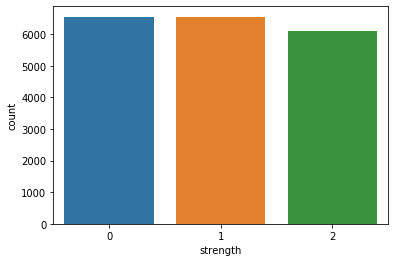

In [5]:
count_class_0, count_class_1, count_class_2 = data.strength.value_counts()
print(data.strength.value_counts())

# Divide by class
df_class_0 = data[data['strength'] == 0]
df_class_1 = data[data['strength'] == 1]
df_class_2 = data[data['strength'] == 2]

df_class_1_under = df_class_1.sample((len(df_class_0)))
df_under = pd.concat([df_class_1_under, df_class_0, df_class_2], axis=0)

print('Random under-sampling:')
print(df_under.strength.value_counts())

sns.countplot(df_under['strength'])

#### hand-designed feature

In [6]:
df1 = df_under.copy()
df1['length'] = df1['password'].str.len()
df1['numerics'] = df1['password'].apply(lambda x: len([str(x) for x in list(x) if str(x).isdigit()]))
df1['alpha'] = df1['password'].apply(lambda x: len([x for x in list(x) if x.isalpha()]))
df1['lowercase'] = df1['password'].apply(lambda x: len([x for x in list(x) if x.islower()]))
df1['uppercase'] = df1['password'].apply(lambda x: len([x for x in list(x) if x.isupper()]))

vowels = ['a', 'e', 'i', 'o', 'u']
df1['vowels'] = df1['password'].apply(lambda x: 
                                      len([x for x in list(x) if x in vowels]))
df1['consonants'] = df1['password'].apply(lambda x: 
                                          len([x for x in list(x) if x not in vowels and x.isalpha()]))
df1['punctuation'] = df1['password'].apply(lambda x: len([x for x in list(x) if x in string.punctuation]))
df1['num_perct'] = df1.apply(lambda x: x['numerics']/x['length'],axis=1)
df1['alpha_perct'] = df1.apply(lambda x: x['alpha']/x['length'],axis=1)

df1.head()

,password,strength,length,numerics,alpha,lowercase,uppercase,vowels,consonants,punctuation,num_perct,alpha_perct
24759,quiere1curl,1,11,1,10,10,0,5,5,0,0.090909,0.909091
13375,yftsixgv27,1,10,2,8,8,0,1,7,0,0.200000,0.800000
39581,mssp365611,1,10,6,4,4,0,0,4,0,0.600000,0.400000
23875,duniq967,1,8,3,5,5,0,2,3,0,0.375000,0.625000
32328,8813188F,1,8,7,1,0,1,0,1,0,0.875000,0.125000


In [7]:
y = df1['strength']
X = df1.drop(['strength'], axis = 1)
X.head()

,password,length,numerics,alpha,lowercase,uppercase,vowels,consonants,punctuation,num_perct,alpha_perct
24759,quiere1curl,11,1,10,10,0,5,5,0,0.090909,0.909091
13375,yftsixgv27,10,2,8,8,0,1,7,0,0.200000,0.800000
39581,mssp365611,10,6,4,4,0,0,4,0,0.600000,0.400000
23875,duniq967,8,3,5,5,0,2,3,0,0.375000,0.625000
32328,8813188F,8,7,1,0,1,0,1,0,0.875000,0.125000


## Training

In [9]:
from sklearn import tree

X_trval, X_test, y_trval, y_test = train_test_split(X, y, test_size = 0.2, random_state=33)
X_train, X_val, y_train, y_val = train_test_split(X_trval, y_trval, test_size = 0.2, random_state=33)
print(f"X_trval:{X_trval.shape}, X_test: {X_test.shape}, X_train: {X_train.shape}, X_val: {X_val.shape}")

X_train = X_train.drop('password', axis = 1)
X_val = X_val.drop('password', axis = 1)
X_test = X_test.drop('password', axis = 1)

X_trval:(15356, 11), X_test: (3839, 11), X_train: (12284, 11), X_val: (3072, 11)


### Model selection

In [10]:
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.neural_network import MLPClassifier
# prepare models
models = []
models.append(('Logistic Regression', LogisticRegression(max_iter=900)))
models.append(('LDA', LinearDiscriminantAnalysis()))
models.append(('KNN', KNeighborsClassifier()))
models.append(('Decision Tree', DecisionTreeClassifier()))
models.append(('Random Forest', RandomForestClassifier()))
models.append(('ADA', AdaBoostClassifier()))
models.append(('Gaussian Naive Bayes', GaussianNB()))
# models.append(('GPC',GaussianProcessClassifier(1.0 * RBF(1.0))))
models.append(('SVM', SVC()))
models.append(('MLP', MLPClassifier(max_iter=600)))

# evaluate each model in turn
results = []
names = []
scoring = 'accuracy'

for name, model in models:
    kfold = model_selection.KFold(n_splits=5, random_state=42,shuffle=True)
    cv_results = model_selection.cross_val_score(model, X_train, y_train, cv=kfold, scoring=scoring)
    results.append(cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)

Logistic Regression: 0.999837 (0.000326)
LDA: 0.964507 (0.004301)
KNN: 0.997721 (0.000552)
Decision Tree: 1.000000 (0.000000)
Random Forest: 1.000000 (0.000000)
ADA: 1.000000 (0.000000)
Gaussian Naive Bayes: 0.925025 (0.006140)
SVM: 0.999430 (0.000326)
MLP: 1.000000 (0.000000)


In [12]:
clf = SVC(random_state=33,gamma='auto')

# Standardize feature 
scaler = StandardScaler().fit(X_train)
X_train_tr = scaler.transform(X_train)
X_test_tr = scaler.transform(X_test)
X_val_tr = scaler.transform(X_val)

# training
clf.fit(X_train_tr, y_train)

# predict
y_train_pred = clf.predict(X_train_tr)
y_val_pred = clf.predict(X_val_tr)

print("Accuracy of SVM Classifier (Training): {0:.3f}".format(accuracy_score(y_train, y_train_pred)))
print("Accuracy of SVM Classifier (Testing): {0:.3f}".format(accuracy_score(y_val, y_val_pred)))

Accuracy of SVM Classifier (Training): 0.999
Accuracy of SVM Classifier (Testing): 0.998


In [13]:
print(classification_report(y_val, y_val_pred))
print(confusion_matrix(y_val, y_val_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1106
           1       1.00      1.00      1.00      1027
           2       1.00      1.00      1.00       939

    accuracy                           1.00      3072
   macro avg       1.00      1.00      1.00      3072
weighted avg       1.00      1.00      1.00      3072

[[1104    1    1]
 [   2 1023    2]
 [   0    0  939]]


In [15]:
df1.columns

Index(['password', 'strength', 'length', 'numerics', 'alpha', 'lowercase',
       'uppercase', 'vowels', 'consonants', 'punctuation', 'num_perct',
       'alpha_perct'],
      dtype='object')

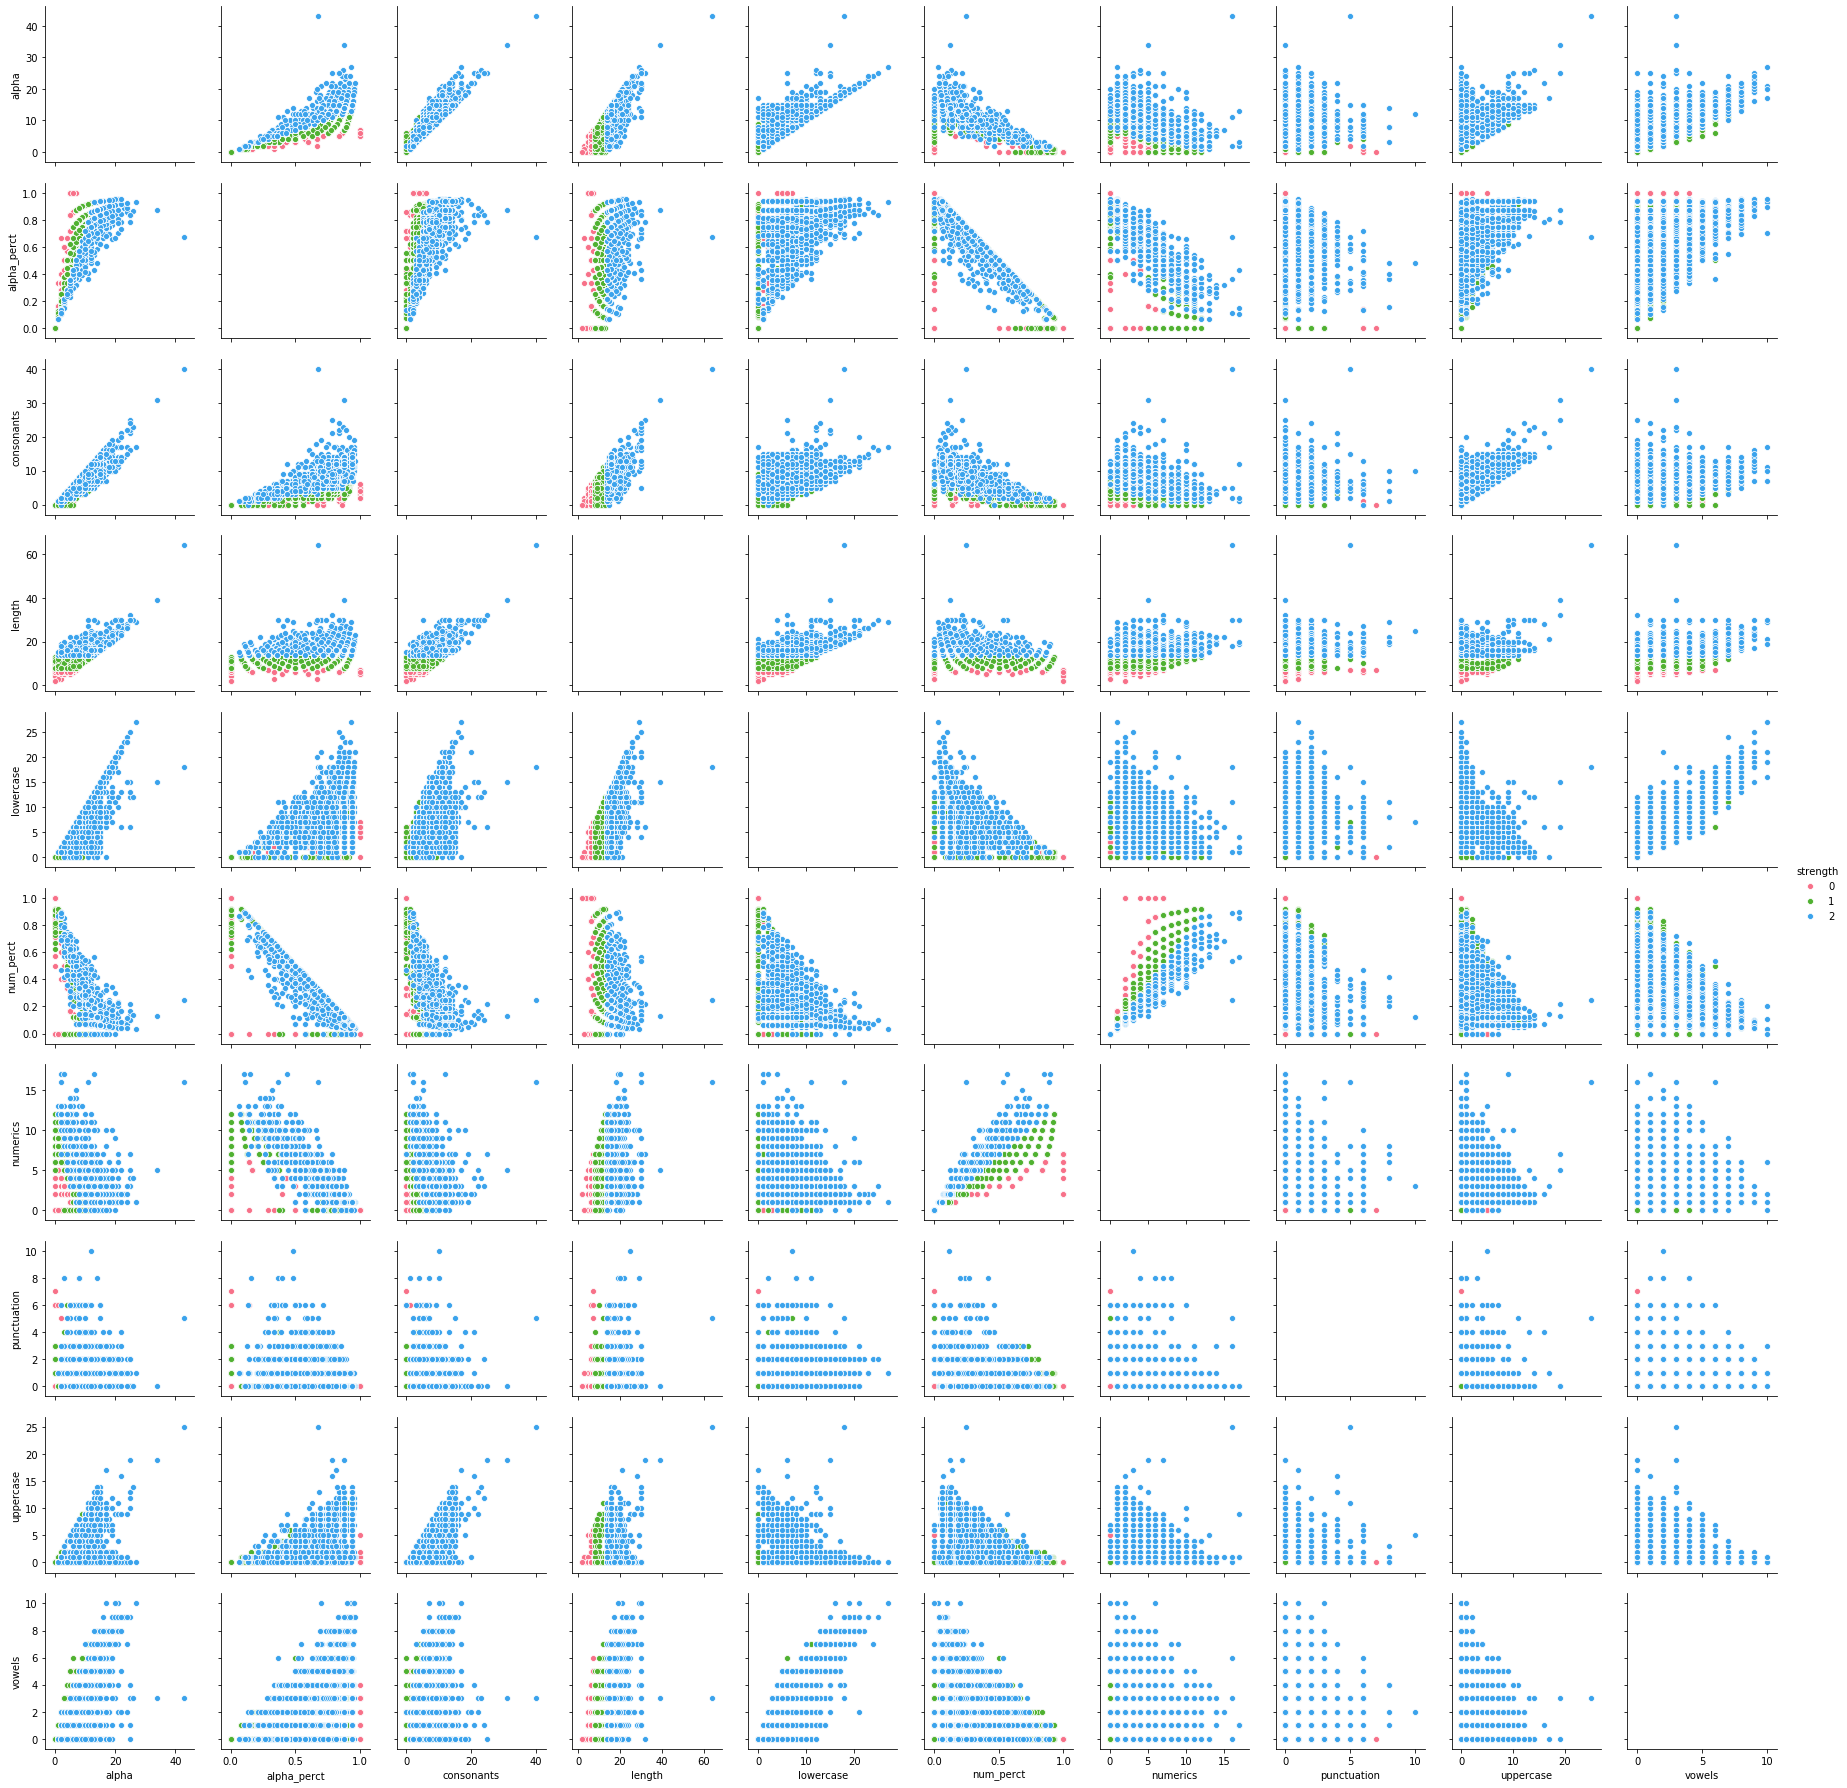

In [21]:
g = sns.pairplot(data = df1, hue = 'strength', vars = df1.columns.difference(['password', 'strength']), 
                 diag_kind = {'kdae'}, palette = 'husl')

### Evaluation

In [14]:
y_test_pred = clf.predict(X_test_tr)
print(classification_report(y_test, y_test_pred))
print(confusion_matrix(y_test, y_test_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1242
           1       1.00      1.00      1.00      1338
           2       1.00      1.00      1.00      1259

    accuracy                           1.00      3839
   macro avg       1.00      1.00      1.00      3839
weighted avg       1.00      1.00      1.00      3839

[[1238    3    1]
 [   4 1333    1]
 [   0    0 1259]]


### Inference